In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
from functools import partial
import json
import traceback
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt 
import pylab

import imlib as im
from imlib.dtype import *
import numpy as np
import pylib
import tensorflow as tf
import tflib as tl

import data
import models

import os
import time
from PIL import Image

os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline


In [47]:
experiment_name = 128
with open('./output/%s/setting.txt' % experiment_name) as f:
    args = json.load(f)

# model
atts = args['atts']
n_att = len(atts)
img_size = args['img_size']
shortcut_layers = args['shortcut_layers']
inject_layers = args['inject_layers']
enc_dim = args['enc_dim']
dec_dim = args['dec_dim']
dis_dim = args['dis_dim']
dis_fc_dim = args['dis_fc_dim']
enc_layers = args['enc_layers']
dec_layers = args['dec_layers']
dis_layers = args['dis_layers']

label = args['label']
use_stu = args['use_stu']
stu_dim = args['stu_dim']
stu_layers = args['stu_layers']
stu_inject_layers = args['stu_inject_layers']
stu_kernel_size = args['stu_kernel_size']
stu_norm = args['stu_norm']
stu_state = args['stu_state']
multi_inputs = args['multi_inputs']
rec_loss_weight = args['rec_loss_weight']
one_more_conv = args['one_more_conv']

dataroot = './data/celeba/'

gpu = 'all'
if gpu != 'all':
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu

use_cropped_img = args['use_cropped_img']
thres_int = args['thres_int']

In [3]:
# ==============================================================================
# =                                   graphs                                   =
# ==============================================================================
# models
Genc = partial(models.Genc, dim=enc_dim, n_layers=enc_layers, multi_inputs=multi_inputs)
Gdec = partial(models.Gdec, dim=dec_dim, n_layers=dec_layers, shortcut_layers=shortcut_layers,
               inject_layers=inject_layers, one_more_conv=one_more_conv)
Gstu = partial(models.Gstu, dim=stu_dim, n_layers=stu_layers, inject_layers=stu_inject_layers,
               kernel_size=stu_kernel_size, norm=stu_norm, pass_state=stu_state)

# inputs
xa_sample = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 3])
_b_sample = tf.placeholder(tf.float32, shape=[None, n_att])
raw_b_sample = tf.placeholder(tf.float32, shape=[None, n_att])

# sample
test_label = _b_sample - raw_b_sample if label == 'diff' else _b_sample
if use_stu:
    x_sample = Gdec(Gstu(Genc(xa_sample, is_training=False),
                         test_label, is_training=False), test_label, is_training=False)
else:
    x_sample = Gdec(Genc(xa_sample, is_training=False), test_label, is_training=False)

W0920 10:46:13.760951 4658943424 deprecation_wrapper.py:119] From /Users/qinshuo/Desktop/face/face_syn/projects/STGAN/models.py:29: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0920 10:46:13.762750 4658943424 deprecation_wrapper.py:119] From /Users/qinshuo/Desktop/face/face_syn/projects/STGAN/models.py:29: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.



 [*] Loading checkpoint succeeds! Copy variables from ./output/128/checkpoints/Epoch_(139)_(947of947).ckpt!
b_sample_ipt_list: [array([[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]])]
raw_a_sample_ipt: [[-0.5 -0.5  0.5 -0.5 -0.5 -0.5  0.5 -0.5 -0.5 -0.5  0.5 -0.5  0.5]]
[[-0.5 -0.5  0.5 -0.5 -0.5 -0.5  0.5 -0.5 -0.5 -0.5 -0.5 -0.5  0.5]]
time cost:1.759s


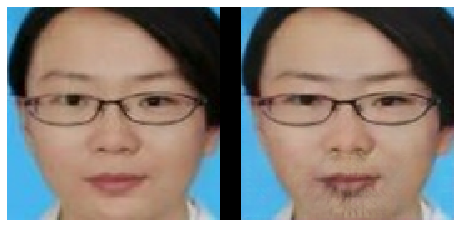

In [84]:
# change multiple attributions at the same time attribute intensity control 
# 'Bald', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Bushy_Eyebrows', 'Eyeglasses', 'Male', 
# 'Mouth_Slightly_Open', 'Mustache', 'No_Beard', 'Pale_Skin', 'Young'

# image to be tested
img_name = './data/red/2433.jpg'
label = np.array([[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1]])

# attributes to be tested
test_atts = ['No_Beard']
test_intens = [1.0]

result_folder = './red_result/'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

sess = tl.session()

# ==============================================================================
# =                                    data                                    =
# ==============================================================================
offset_h = 26
offset_w = 3
img_resize = 170
img = tf.read_file(img_name)
img = tf.image.decode_jpeg(img, 3)
# img = tf.image.crop_to_bounding_box(img, offset_h, offset_w, img_resize, img_resize)
img = tf.image.resize_images(img, [img_size, img_size], tf.image.ResizeMethod.BICUBIC)
img = tf.clip_by_value(img, 0, 255) / 127.5 - 1
img = img.eval(session=sess)

# img = Image.open(img_name).convert('RGB')
# print(img.size)
# img = np.array(img.resize((img_size, img_size))) / 127.5 - 1
# img = np.expand_dims(img, 0)

# ==============================================================================
# =                                    test                                    =
# ==============================================================================

# initialization
ckpt_dir = './output/%s/checkpoints' % experiment_name
tl.load_checkpoint(ckpt_dir, sess)
multi_atts = test_atts is not None
idx = 0
batch = (img, label)
xa_sample_ipt = [batch[0]]
a_sample_ipt = batch[1]
b_sample_ipt_list = [a_sample_ipt.copy()]

for index, a in enumerate(test_atts):
    i = atts.index(a)
    # overturn all attribution values in a_sample_ipt that appear in test_atts
    b_sample_ipt_list[-1][:, i] = 1 - b_sample_ipt_list[-1][:, i]
    b_sample_ipt_list[-1] = data.Celeba.check_attribute_conflict(b_sample_ipt_list[-1], atts[i], atts)
print('b_sample_ipt_list:', b_sample_ipt_list)

x_sample_opt_list = [xa_sample_ipt, np.full((1, img_size, img_size // 10, 3), -1.0)]

# make raw_a_sample_ipt uniform distribution in [-1, 1]
raw_a_sample_ipt = a_sample_ipt.copy()
raw_a_sample_ipt = (raw_a_sample_ipt * 2 - 1) * thres_int
print('raw_a_sample_ipt:', raw_a_sample_ipt)

# calculate the intensity value of _b_sample_ipt according to test_ints
for i, b_sample_ipt in enumerate(b_sample_ipt_list):
    _b_sample_ipt = (b_sample_ipt * 2 - 1) * thres_int
    for t_att, t_int in zip(test_atts, test_intens):
        _b_sample_ipt[..., atts.index(t_att)] = _b_sample_ipt[..., atts.index(t_att)] * float(t_int)

    print(_b_sample_ipt)

    start_time = time.time()
    x_sample_opt_list.append(sess.run(x_sample, feed_dict={xa_sample: xa_sample_ipt,
                                                           _b_sample: _b_sample_ipt,
                                                           raw_b_sample: raw_a_sample_ipt}))
    duration = time.time() - start_time
    print('time cost:{:.3f}s'.format(duration))

sample = np.concatenate(x_sample_opt_list, 2)
img = Image.fromarray(to_range(sample.squeeze(0), 0, 255, np.uint8))
img.save(os.path.join(result_folder, img_name.split('/')[-1]))

pylab.rcParams['figure.figsize'] = (8.0, 4.0)
plt.imshow(img)
plt.axis('off')
plt.show()
# img.show()